In [1]:
#!pip install tensorflow-gpu

In [2]:
#!pip install --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.12.0-py3-none-any.whl

In [3]:
#!pip install tensorflow --upgrade

In [12]:
#!pip install tensorflow-hub

In [1]:
!pip install tf-slim

     |████████████████████████████████| 352 kB 4.4 MB/s 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random
import os, sys
import tf_slim

import warnings
warnings.filterwarnings("ignore")

from tensorflow.python.ops.rnn import _transpose_batch_time
from sklearn.model_selection import train_test_split

#performance metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import normalized_mutual_info_score, homogeneity_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix

In [5]:
#user defined
from utils_log import save_logging, load_logging
from data_loader import import_data
from class_AC_TPC import AC_TPC, initialize_embedding

In [6]:
def f_get_minibatch(mb_size, x, y):
    idx = range(np.shape(x)[0])
    idx = random.sample(idx, mb_size)

    x_mb   = x[idx].astype(float)    
    y_mb   = y[idx].astype(float)    

    return x_mb, y_mb

### PERFORMANCE METRICS:
def f_get_prediction_scores(y_true_, y_pred_):
    if np.sum(y_true_) == 0: #no label for running roc_auc_curves
        auroc_ = -1.
        auprc_ = -1.
    else:
        auroc_ = roc_auc_score(y_true_, y_pred_)
        auprc_ = average_precision_score(y_true_, y_pred_)
    return (auroc_, auprc_)


def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    c_matrix = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(c_matrix, axis=0)) / np.sum(c_matrix)

In [11]:
data_name = 'sample'
data_x, data_y, y_type = import_data(data_name = data_name)

In [12]:
seed = 1234

tr_data_x,te_data_x, tr_data_y,te_data_y = train_test_split(
    data_x, data_y, test_size=0.2, random_state=seed
)

tr_data_x,va_data_x, tr_data_y,va_data_y = train_test_split(
    tr_data_x, tr_data_y, test_size=0.2, random_state=seed
)

In [17]:
data_x.shape

(1346, 23, 35)

In [9]:
K = 6

h_dim_FC   = 50 #for fully_connected layers
h_dim_RNN  = 50

x_dim = np.shape(data_x)[2]
y_dim = np.shape(data_y)[2]
  
    
num_layer_encoder    = 1
num_layer_selector   = 2
num_layer_predictor  = 2

z_dim = h_dim_RNN * num_layer_encoder

max_length = np.shape(data_x)[1]

rnn_type          = 'LSTM' #GRU, LSTM


input_dims ={
    'x_dim': x_dim,
    'y_dim': y_dim,
    'y_type': y_type,
    'max_cluster': K,
    'max_length': max_length    
}

network_settings ={
    'h_dim_encoder': h_dim_RNN,
    'num_layers_encoder': num_layer_encoder,
    'rnn_type': rnn_type,
    'rnn_activate_fn': tf.nn.tanh,

    'h_dim_selector': h_dim_FC,
    'num_layers_selector': num_layer_selector,
    
    'h_dim_predictor': h_dim_FC,
    'num_layers_predictor': num_layer_predictor,
    
    'fc_activate_fn': tf.nn.relu
}

In [10]:
lr_rate    = 0.001
keep_prob  = 0.7
mb_size    = 128

#ITERATION  = 10000
ITERATION  = 5000
check_step = 1000

save_path = './{}/proposed/init/'.format(data_name)

if not os.path.exists(save_path + '/models/'):
    os.makedirs(save_path + '/models/')

In [11]:
def log(x): 
    return tf.log(x + 1e-8)

def div(x, y):
    return tf.div(x, (y + 1e-8))

def get_seq_length(sequence):
    used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
    tmp_length = tf.reduce_sum(used, 1)
    tmp_length = tf.cast(tmp_length, tf.int32)
    return tmp_length

In [15]:
#from tensorflow.contrib.layers import fully_connected as FC_Net
from tf_slim.layers import fully_connected as FC_Net

### CONSTRUCT MULTICELL FOR MULTI-LAYER RNNS
def create_rnn_cell(num_units, num_layers, keep_prob, RNN_type, activation_fn): 
    '''
        GOAL         : create multi-cell (including a single cell) to construct multi-layer RNN
        num_units    : number of units in each layer
        num_layers   : number of layers in MulticellRNN
        keep_prob    : keep probabilty [0, 1]  (if None, dropout is not employed)
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    if activation_fn == 'None':
        activation_fn = tf.nn.tanh

    cells = []
    for _ in range(num_layers):
        if RNN_type == 'GRU':
            cell = tf.nn.rnn_cell.GRUCell(num_units, activation=activation_fn)
        elif RNN_type == 'LSTM':
            cell = tf.nn.rnn_cell.LSTMCell(num_units, activation=activation_fn, state_is_tuple=True)
            # cell = tf.contrib.rnn.LSTMCell(num_units, activation=activation_fn)
        else:
        	print('ERROR: WRONG RNN TYPE')
        if not keep_prob is None:
            cell = tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob) # state_keep_prob=keep_prob
        cells.append(cell)
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    return cell


### EXTRACT STATE OUTPUT OF MULTICELL-RNNS
def create_concat_state_h(state, num_layers, RNN_type, BiRNN=None):
    '''
        GOAL	     : concatenate the tuple-type tensor (state) into a single tensor
        state        : input state is a tuple ofo MulticellRNN (i.e. output of MulticellRNN)
                       consist of only hidden states h for GRU and hidden states c and h for LSTM
        num_layers   : number of layers in MulticellRNN
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    for i in range(num_layers):
        if BiRNN != None:
            if RNN_type == 'LSTM':
                tmp = tf.concat([state[0][i][1], state[1][i][1]], axis=1) ## i-th layer, h state for LSTM
            elif RNN_type == 'GRU':
                tmp = tf.concat([state[0][i], state[1][i]], axis=1) ## i-th layer, h state for GRU
            else:
                print('ERROR: WRONG RNN CELL TYPE')
        else:
            if RNN_type == 'LSTM':
                tmp = state[i][1] ## i-th layer, h state for LSTM
            elif RNN_type == 'GRU':
                tmp = state[i] ## i-th layer, h state for GRU
            else:
                print('ERROR: WRONG RNN CELL TYPE')

        if i == 0:
            rnn_state_out = tmp
        else:
            rnn_state_out = tf.concat([rnn_state_out, tmp], axis = 1)
    
    return rnn_state_out


def create_concat_state_c(state, num_layers, RNN_type, BiRNN=None):
    for i in range(num_layers):
        if BiRNN != None:
            if RNN_type == 'LSTM':
                tmp = tf.concat([state[0][i][0], state[1][i][0]], axis=1) ## i-th layer, c state for LSTM
            elif RNN_type == 'GRU':
                tmp = tf.concat([state[0][i], state[1][i]], axis=1) ## i-th layer, c=h state for GRU
            else:
                print('ERROR: WRONG RNN CELL TYPE')
        else:
            if RNN_type == 'LSTM':
                tmp = state[i][0] ## i-th layer, c state for LSTM
            elif RNN_type == 'GRU':
                tmp = state[i] ## i-th layer, h state for GRU
            else:
                print('ERROR: WRONG RNN CELL TYPE')

        if i == 0:
            rnn_state_out = tmp
        else:
            rnn_state_out = tf.concat([rnn_state_out, tmp], axis = 1)
    
    return rnn_state_out

### FEEDFORWARD NETWORK
def create_FCNet(inputs, num_layers, h_dim, h_fn, o_dim, o_fn, w_init, w_reg=None, keep_prob=1.0):
    '''
        GOAL             : Create FC network with different specifications 
        inputs (tensor)  : input tensor
        num_layers       : number of layers in FCNet
        h_dim  (int)     : number of hidden units
        h_fn             : activation function for hidden layers (default: tf.nn.relu)
        o_dim  (int)     : number of output units
        o_fn             : activation function for output layers (defalut: None)
        w_init           : initialization for weight matrix (defalut: Xavier)
        keep_prob        : keep probabilty [0, 1]  (if None, dropout is not employed)
    '''
    # default active functions (hidden: relu, out: None)
    if h_fn is None:
        h_fn = tf.nn.relu
    if o_fn is None:
        o_fn = None

    # default initialization functions (weight: Xavier, bias: None)
    if w_init is None:
        w_init = tf.contrib.layers.xavier_initializer() # Xavier initialization

    for layer in range(num_layers):
        if num_layers == 1:
            out = FC_Net(inputs, o_dim, activation_fn=o_fn, weights_initializer=w_init, weights_regularizer=w_reg)
        else:
            if layer == 0:
                h = FC_Net(inputs, h_dim, activation_fn=h_fn, weights_initializer=w_init, weights_regularizer=w_reg)
                if not keep_prob is None:
                    h = tf.nn.dropout(h, keep_prob=keep_prob)

            elif layer > 0 and layer != (num_layers-1): # layer > 0:
                h = FC_Net(h, h_dim, activation_fn=h_fn, weights_initializer=w_init, weights_regularizer=w_reg)
                if not keep_prob is None:
                    h = tf.nn.dropout(h, keep_prob=keep_prob)

            else: # layer == num_layers-1 (the last layer)
                out = FC_Net(h, o_dim, activation_fn=o_fn, weights_initializer=w_init, weights_regularizer=w_reg)

    return out


In [16]:
class AC_TPC:
    def __init__(self, sess, name, input_dims, network_settings):
        self.sess               = sess
        self.name               = name
        
        # INPUT/OUTPUT DIMENSIONS
        self.x_dim           = input_dims['x_dim'] #features + delta
        self.y_dim           = input_dims['y_dim']
        self.y_type          = input_dims['y_type']
        self.K               = input_dims['max_cluster']
        self.max_length      = input_dims['max_length']

        # Encoder
        self.h_dim_f         = network_settings['h_dim_encoder'] #encoder nodes
        self.num_layers_f    = network_settings['num_layers_encoder'] #encoder layers
        self.rnn_type        = network_settings['rnn_type']
        self.rnn_activate_fn   = network_settings['rnn_activate_fn']

        # Selector
        self.h_dim_h         = network_settings['h_dim_selector'] #selector nodes
        self.num_layers_h    = network_settings['num_layers_selector'] #selector layers
        
        # Predictor
        self.h_dim_g         = network_settings['h_dim_predictor'] #predictor nodes
        self.num_layers_g    = network_settings['num_layers_predictor'] #predictor layers
        
        self.fc_activate_fn  = network_settings['fc_activate_fn'] #selector & predictor
        
        # Latent Space
        self.z_dim           = self.h_dim_f * self.num_layers_f

        self._build_net()

    def _build_net(self):
        with tf.compat.v1.variable_scope(self.name):            
            self.mb_size     = tf.placeholder(tf.int32, [], name='batch_size')
            self.lr_rate1    = tf.placeholder(tf.float32, name='learning_rate1')
            self.lr_rate2    = tf.placeholder(tf.float32, name='learning_rate2')
            self.keep_prob   = tf.placeholder(tf.float32, name='keep_probability')

            # Input and Output
            self.x          = tf.placeholder(tf.float32, [None, self.max_length, self.x_dim], name='inputs')
            self.y          = tf.placeholder(tf.float32, [None, self.max_length, self.y_dim], name='labels_onehot')
            
            # Embedding
            self.E          = tf.placeholder(tf.float32, [self.K, self.z_dim], name='embeddings_input')
            self.EE         = tf.Variable(self.E, name='embeddings_var')
            self.embeddings = tf.nn.tanh(self.EE)

            # self.embde         = tf.nn.tanh(self.EE)
            # self.EE         = tf.Variable(self.E, name='embeddings_var')
            
            self.s          = tf.placeholder(tf.int32, [None], name='cluster_label')
            self.s_onehot   = tf.one_hot(self.s, self.K)

            # LOSS PARAMETERS
            self.alpha      = tf.placeholder(tf.float32, name = 'alpha') #For sample-wise entropy
            self.beta       = tf.placeholder(tf.float32, name = 'beta')  #For prediction loss (i.e., mle)
            self.gamma      = tf.placeholder(tf.float32, name = 'gamma') #For batch-wise entropy
            self.delta      = tf.placeholder(tf.float32, name = 'delta') #For embedding

            '''
                ### CREATE RNN MASK
                    - This is to flexibly handle sequences with different length
                    - rnn_mask1: last observation; [mb_size, max_length]
                    - rnn_mask2: all available observations; [mb_size, max_length]
            '''
            # CREATE RNN MASK:            
            seq_length     = get_seq_length(self.x)
            tmp_range      = tf.expand_dims(tf.range(0, self.max_length, 1), axis=0)
            self.rnn_mask1 = tf.cast(tf.equal(tmp_range, tf.expand_dims(seq_length-1, axis=1)), tf.float32) #last observation
            self.rnn_mask2 = tf.cast(tf.less_equal(tmp_range, tf.expand_dims(seq_length-1, axis=1)), tf.float32) #all available observation
            
            
            ### DEFINE SELECTOR
            def selector(x_, o_dim_=self.K, num_layers_=2, h_dim_=self.h_dim_h, activation_fn=self.fc_activate_fn, reuse=tf.AUTO_REUSE):
                out_fn = tf.nn.softmax
                with tf.compat.v1.variable_scope('selector', reuse=reuse):
                    if num_layers_ == 1:
                        out =  tf_slim.layers.fully_connected(inputs=x_, num_outputs=o_dim_, activation_fn=out_fn, scope='selector_out')
                    else: #num_layers > 1
                        for tmp_layer in range(num_layers_-1):
                            if tmp_layer == 0:
                                net = x_
                            net = tf_slim.layers.fully_connected(inputs=net, num_outputs=h_dim_, activation_fn=activation_fn, scope='selector_'+str(tmp_layer))
                            net = tf.nn.dropout(net, keep_prob=self.keep_prob)
                        out =  tf_slim.layers.fully_connected(inputs=net, num_outputs=o_dim_, activation_fn=out_fn, scope='selector_out')  
                return out
            
            
            ### DEFINE PREDICTOR
            def predictor(x_, o_dim_=self.y_dim, o_type_=self.y_type, num_layers_=1, h_dim_=self.h_dim_g, activation_fn=self.fc_activate_fn, reuse=tf.AUTO_REUSE):
                if o_type_ == 'continuous':
                    out_fn = None
                elif o_type_ == 'categorical':
                    out_fn = tf.nn.softmax #for classification task
                elif o_type_ == 'binary':
                    out_fn = tf.nn.sigmoid
                else:
                    raise Exception('Wrong output type. The value {}!!'.format(o_type_))
                    
                with tf.compat.v1.variable_scope('predictor', reuse=reuse):
                    if num_layers_ == 1:
                        out =  tf.contrib.layers.fully_connected(inputs=x_, num_outputs=o_dim_, activation_fn=out_fn, scope='predictor_out')
                    else: #num_layers > 1
                        for tmp_layer in range(num_layers_-1):
                            if tmp_layer == 0:
                                net = x_
                            net = tf_slim.layers.fully_connected(inputs=net, num_outputs=h_dim_, activation_fn=activation_fn, scope='predictor_'+str(tmp_layer))
                            net = tf.nn.dropout(net, keep_prob=self.keep_prob)
                        out =  tf_slim.layers.fully_connected(inputs=net, num_outputs=o_dim_, activation_fn=out_fn, scope='predictor_out')  
                return out

            
            ### DEFINE LOOP FUNCTION FOR ENCODRER (f-g, f-h relations are created here)
            def loop_fn(time, cell_output, cell_state, loop_state):
                
                emit_output = cell_output 

                if cell_output is None:  # time == 0
                    next_cell_state = cell.zero_state(self.mb_size, tf.float32)
                    next_loop_state = loop_state_ta
                else:
                    next_cell_state = cell_state
                    tmp_z  = create_concat_state_h(next_cell_state, self.num_layers_f, self.rnn_type)      
                    tmp_y  = predictor(tmp_z, self.y_dim, self.y_type, self.num_layers_g, self.h_dim_g, self.fc_activate_fn)        
                    tmp_pi = selector(tmp_z, self.K, self.num_layers_h, self.h_dim_h, self.fc_activate_fn)

                    next_loop_state = (loop_state[0].write(time-1, tmp_z),  # save all the hidden states
                                       loop_state[1].write(time-1, tmp_y),  # save all the output
                                       loop_state[2].write(time-1, tmp_pi)) # save all the selector_net output (i.e., pi)

                elements_finished = (time >= self.max_length)

                #this gives the break-point (no more recurrence after the max_length)
                finished = tf.reduce_all(elements_finished)    
                next_input = tf.cond(finished, 
                                     lambda: tf.zeros([self.mb_size, self.x_dim], dtype=tf.float32),  
                                     lambda: inputs_ta.read(time))
                return (elements_finished, next_input, next_cell_state, emit_output, next_loop_state)

            
            '''
                ##### CREATE RNN NETWORK
                    - (INPUT)  inputs_ta: TensorArray with [max_length, mb_size, x_dim] #x_dim included delta
                    - (OUTPUT) 
                        . zs     = rnn states (h) in LSTM/GRU             ; [mb_size, max_length z_dim]
                        . y_hats = output of predictor taking zs as inputs; [mb_size, max_length, y_dim]
                        . pis    = output of selector                     ; [mb_size, max_length, K]

            '''
            inputs    = self.x
            inputs_ta = tf.TensorArray(
                dtype=tf.float32, size=self.max_length
            ).unstack(_transpose_batch_time(inputs), name = 'rnn_input')


            cell = create_rnn_cell(
                self.h_dim_f, self.num_layers_f, 
                self.keep_prob, self.rnn_type, self.rnn_activate_fn
            )

            #define the loop_state TensorArray for information from rnn time steps
            loop_state_ta = (
                tf.TensorArray(size=self.max_length, dtype=tf.float32, clear_after_read=False),  #zs (j=1,...,J)
                tf.TensorArray(size=self.max_length, dtype=tf.float32, clear_after_read=False),  #y_hats (j=1,...,J)
                tf.TensorArray(size=self.max_length, dtype=tf.float32, clear_after_read=False)   #pis (j=1,...,J)
            )  

            _, _, loop_state_ta = tf.nn.raw_rnn(cell, loop_fn) #, parallel_iterations=1)


            self.zs         = _transpose_batch_time(loop_state_ta[0].stack())
            self.y_hats     = _transpose_batch_time(loop_state_ta[1].stack())
            self.pis        = _transpose_batch_time(loop_state_ta[2].stack())

            ### SAMPLING PROCESS
            s_dist          = tf.distributions.Categorical(probs=tf.reshape(self.pis, [-1, self.K])) #define the categorical dist.
            s_sample        = s_dist.sample()

            mask_e          = tf.cast(tf.equal(tf.expand_dims(tf.range(0, self.K, 1), axis=0), tf.expand_dims(s_sample, axis=1)), tf.float32)
            z_bars          = tf.matmul(mask_e, self.embeddings)
            pi_sample       = tf.reduce_sum(mask_e * tf.reshape(log(self.pis), [-1, self.K]), axis=1)

            with tf.compat.v1.variable_scope('rnn', reuse=True):
                y_bars   = predictor(z_bars, self.y_dim, self.y_type, self.num_layers_g, self.h_dim_g, self.fc_activate_fn)

            self.z_bars    = tf.reshape(z_bars, [-1, self.max_length, self.z_dim])
            self.y_bars    = tf.reshape(y_bars, [-1, self.max_length, self.y_dim])
            self.pi_sample = tf.reshape(pi_sample, [-1, self.max_length])
            self.s_sample  = tf.reshape(s_sample, [-1, self.max_length])

            
            ### DEFINE LOSS FUNCTIONS
            #\ell_{1}: KL divergence loss for regression and binary/categorical-classification task
            def loss_1(y_true_, y_pred_, y_type_ = self.y_type):                
                if y_type_ == 'continuous':
                    tmp_loss = tf.reduce_sum((y_true_ - y_pred_)**2, axis=-1)
                elif y_type_ == 'categorical':
                    tmp_loss = - tf.reduce_sum(y_true_ * log(y_pred_), axis=-1)
                elif y_type_ == 'binary':
                    tmp_loss = - tf.reduce_sum(y_true_ * log(y_pred_) + (1.-y_true_) * log(1.-y_pred_), axis=-1)
                else:
                    raise Exception('Wrong output type. The value {}!!'.format(y_type_))                    
                return tmp_loss

            #batch-wise entropy
            tmp_pis   = tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.K]) * self.pis
            mean_pis  = tf.reduce_sum(tf.reduce_sum(tmp_pis, axis=1), axis=0) / tf.reduce_sum(tf.reduce_sum(self.rnn_mask2, axis=1), axis=0, keepdims=True)

            ## LOSS_MLE: MLE prediction loss (for initalization)
            self.LOSS_MLE   = tf.reduce_mean(tf.reduce_sum(self.rnn_mask2 * loss_1(self.y, self.y_hats, self.y_type), axis=1))
            
            
            ## LOSS1: predictive clustering loss
            self.LOSS_1     = tf.reduce_mean(tf.reduce_sum(self.rnn_mask2 * loss_1(self.y, self.y_bars, self.y_type), axis=1))
            self.LOSS_1_AC  = tf.reduce_mean(tf.reduce_sum(self.rnn_mask2 * self.pi_sample * loss_1(self.y, self.y_bars, self.y_type), axis=1))

            ## LOSS2: sample-wise entropy loss
            self.LOSS_2     = tf.reduce_mean(-tf.reduce_sum(self.rnn_mask2 * tf.reduce_sum(self.pis * log(self.pis), axis=2), axis=1))
            
            
            predictor_vars  = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope= self.name+'/rnn/predictor')
            selecter_vars   = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope= self.name+'/rnn/selector')
            embedding_vars  = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope= self.name+'/embeddings_var')
            encoder_vars    = [vars_ for vars_ in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) 
                               if vars_ not in predictor_vars+selecter_vars+embedding_vars]
            
            ### EMBEDDING TRAINING
            with tf.compat.v1.variable_scope('rnn', reuse=True):
                Ey   = predictor(self.embeddings, self.y_dim, self.y_type, self.num_layers_g, self.h_dim_g, self.fc_activate_fn)
                # Ey   = predictor(self.EE, self.y_dim, self.y_type, self.num_layers_g, self.h_dim_g, self.fc_activate_fn)

            ## LOSS3: embedding separation loss (prevents embedding from collapsing)
            self.LOSS_3 = 0
            for i in range(self.K):
                for j in range(i+1, self.K):
                    self.LOSS_3 += - loss_1(Ey[i, :], Ey[j, :], y_type_ = self.y_type) / ((self.K-1)*(self.K-2)) # negative because we want to increase this;
                    
            
            ### DEFINE OPTIMIZATION SOLVERS
            self.solver_MLE           = tf.train.AdamOptimizer(self.lr_rate1).minimize(
                self.LOSS_MLE, var_list=encoder_vars+predictor_vars
            )
            self.solver_L1_critic     = tf.train.AdamOptimizer(self.lr_rate1).minimize(
                self.LOSS_1,
                var_list=encoder_vars+predictor_vars
            )
            self.solver_L1_actor      = tf.train.AdamOptimizer(self.lr_rate2).minimize(
                self.LOSS_1_AC + self.alpha*self.LOSS_2, 
                var_list=encoder_vars + selecter_vars
            )            
            self.solver_E             = tf.train.AdamOptimizer(self.lr_rate1).minimize(
                self.LOSS_1 + self.beta*self.LOSS_3, 
                var_list=embedding_vars
            )

            ### INITIALIZE SELECTOR
            self.zz     = tf.placeholder(tf.float32, [None, self.z_dim])
            with tf.compat.v1.variable_scope('rnn', reuse=True):
                self.yy    = predictor(self.zz, self.y_dim, self.y_type, self.num_layers_g, self.h_dim_g, self.fc_activate_fn) #to check the predictor output given z
                self.s_out = selector(self.zz, self.K, self.num_layers_h, self.h_dim_h, self.fc_activate_fn)
            
            ## LOSS_S: selector initialization (cross-entropy wrt initialized class)
            self.LOSS_S   = tf.reduce_mean(- tf.reduce_sum(self.s_onehot*log(self.s_out), axis=1))
            self.solver_S = tf.train.AdamOptimizer(self.lr_rate1).minimize(
                self.LOSS_S, var_list=selecter_vars
            )
            
    ### TRAINING FUNCTIONS        
    def train_mle(self, x_, y_, lr_train, k_prob):
        return self.sess.run([self.solver_MLE, self.LOSS_MLE],
                             feed_dict={self.x: x_, self.y: y_,
                                        self.mb_size:np.shape(x_)[0], self.lr_rate1: lr_train, self.keep_prob: k_prob})
    
    def train_critic(self, x_, y_, lr_train, k_prob):
        return self.sess.run([self.solver_L1_critic, self.LOSS_1],
                             feed_dict={self.x: x_, self.y: y_, 
                                        self.mb_size:np.shape(x_)[0], self.lr_rate1: lr_train, self.keep_prob: k_prob})
    
    def train_actor(self, x_, y_, alpha_, lr_train, k_prob):
        return self.sess.run([self.solver_L1_actor, self.LOSS_1, self.LOSS_2],
                             feed_dict={self.x: x_, self.y: y_,
                                        self.alpha: alpha_,
                                        self.mb_size:np.shape(x_)[0], self.lr_rate2: lr_train, self.keep_prob: k_prob})
    
    def train_selector(self, z_, s_, lr_train, k_prob):
        return self.sess.run([self.solver_S, self.LOSS_S],
                             feed_dict={self.zz: z_, self.s: s_, 
                                        self.lr_rate1: lr_train, self.keep_prob: k_prob})
    
    def train_embedding(self, x_, y_, beta_, lr_train, k_prob):   
        return self.sess.run([self.solver_E, self.LOSS_1, self.LOSS_3], 
                             feed_dict={self.x:x_, self.y:y_,
                                        self.beta:beta_,
                                        self.mb_size:np.shape(x_)[0], 
                                        self.lr_rate1:lr_train, self.keep_prob:k_prob})

    def get_losses(self, x_, y_):   
        return self.sess.run([self.LOSS_1, self.LOSS_2, self.LOSS_3], 
                             feed_dict={self.x:x_, self.y:y_,
                                        self.mb_size:np.shape(x_)[0], 
                                        self.keep_prob:1.0})
        
    ### PREDICTION FUNCTIONS
    def predict_y_hats(self, x_):
        return self.sess.run([self.y_hats, self.rnn_mask2], 
                             feed_dict={self.x:x_, self.mb_size:np.shape(x_)[0], self.keep_prob:1.0})
    
    def predict_y_bars(self, x_):
        return self.sess.run([self.y_bars, self.rnn_mask2], 
                             feed_dict={self.x:x_, self.mb_size:np.shape(x_)[0], self.keep_prob:1.0})
    
    def predict_yy(self, z_):
        return self.sess.run(self.yy,
                             feed_dict={self.zz:z_, self.mb_size:np.shape(z_)[0], self.keep_prob:1.0})
        
    def predict_zs_and_pis_m2(self, x_):
        return self.sess.run([self.zs, self.pis, self.rnn_mask2], 
                             feed_dict={self.x:x_, self.mb_size:np.shape(x_)[0], self.keep_prob:1.0})
    
    def predict_s_sample(self, x_):
        return self.sess.run([self.s_sample, self.rnn_mask2], 
                             feed_dict={self.x:x_, self.mb_size:np.shape(x_)[0], self.keep_prob:1.0})
    
    def predict_zbars_and_pis_m1(self, x_):
        return self.sess.run([self.z_bars, self.pis, self.rnn_mask1], 
                             feed_dict={self.x:x_, self.mb_size:np.shape(x_)[0], self.keep_prob:1.0})
    
    def predict_zs_and_pis_m1(self, x_):
        return self.sess.run([self.zs, self.pis, self.rnn_mask1], 
                             feed_dict={self.x:x_, self.mb_size:np.shape(x_)[0], self.keep_prob:1.0})
    
    def predict_zbars_and_pis_m2(self, x_):
        return self.sess.run([self.z_bars, self.pis, self.rnn_mask2], 
                             feed_dict={self.x:x_, self.mb_size:np.shape(x_)[0], self.keep_prob:1.0})




In [17]:
from tensorflow.core.framework.full_type_pb2 import TFT_INT32
print('Initialize Network...')

from tensorflow.python.framework import ops
ops.reset_default_graph()

# Turn on xla optimization
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

model = AC_TPC(sess, "AC_TPC", input_dims, network_settings)


saver = tf.train.Saver()
sess.run(tf.global_variables_initializer(), feed_dict={model.E:np.zeros([K, z_dim]).astype(float)})

avg_loss  = 0
for itr in range(ITERATION):
    x_mb, y_mb  = f_get_minibatch(mb_size, tr_data_x, tr_data_y)

    _, tmp_loss = model.train_mle(x_mb, y_mb, lr_rate, keep_prob)
    avg_loss   += tmp_loss/check_step

    if (itr+1)%check_step == 0:                
        tmp_y, tmp_m = model.predict_y_hats(va_data_x)

        y_pred = tmp_y.reshape([-1, y_dim])[tmp_m.reshape([-1]) == 1]
        y_true = va_data_y.reshape([-1, y_dim])[tmp_m.reshape([-1]) == 1]

        AUROC = np.zeros([y_dim])
        AUPRC = np.zeros([y_dim])
        for y_idx in range(y_dim):
            auroc, auprc = f_get_prediction_scores(y_true[:, y_idx], y_pred[:, y_idx])
            AUROC[y_idx] = auroc
            AUPRC[y_idx] = auprc

        print ("ITR {:05d}: loss_2={:.3f} | va_auroc:{:.3f}, va_auprc:{:.3f}".format(
                itr+1, avg_loss, np.mean(AUROC), np.mean(AUPRC))
              )        
        avg_loss = 0

saver.save(sess, save_path + 'models/model_K{}'.format(K))
save_logging(network_settings, save_path + 'models/network_settings_K{}.txt'.format(K))

Initialize Network...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:988: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  partitioner=maybe_partitioner)
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:996: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=initializer)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.random.categorical` instead.
ITR 01000: loss_2=2.322 | va_auroc:0.916, va_auprc:0.665
ITR 02000: loss_2=1.321 | va_auroc:0.901, va_auprc:0.640
ITR 03000: loss_2=1.104 | va_auroc:0.897, va_auprc:0.626
ITR 04000: loss_2=0.956 | va_auroc:0.896, va_auprc:0.620
ITR 05000: loss_2=0.869 | va_auroc:0.888, va_auprc:0.617


In [19]:
alpha  = 1.0
beta   = 0.01

mb_size    = 128
M          = int(tr_data_x.shape[0]/mb_size) #for main algorithm
keep_prob  = 0.7
lr_rate1   = 1e-3
lr_rate2   = 1e-3

save_path = './{}/proposed/trained/'.format(data_name)

if not os.path.exists(save_path + '/models/'):
    os.makedirs(save_path + '/models/')

if not os.path.exists(save_path + '/results/'):
    os.makedirs(save_path + '/results/')

In [20]:
### LOAD INITIALIZED NETWORK

load_path = './{}/proposed/init/'.format(data_name)

tf.reset_default_graph()

# Turn on xla optimization
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

network_settings = load_logging(load_path + 'models/network_settings_K{}.txt'.format(K))
z_dim = network_settings['num_layers_encoder'] * network_settings['h_dim_encoder']

model = AC_TPC(sess, "AC_TPC", input_dims, network_settings)

saver = tf.train.Saver()
saver.restore(sess, load_path + 'models/model_K{}'.format(K))

INFO:tensorflow:Restoring parameters from ./sample/proposed/init/models/model_K6


In [21]:
print('=============================================')
print('===== INITIALIZING EMBEDDING & SELECTOR =====')
# K-means over the latent encodings
e, s_init, tmp_z = initialize_embedding(model, tr_data_x, K)
e = np.arctanh(e)
sess.run(model.EE.initializer, feed_dict={model.E:e}) #model.EE = tf.nn.tanh(model.E)

# update selector wrt initial classes
ITERATION  = 5000
check_step = 1000

avg_loss_s = 0
for itr in range(ITERATION):
    z_mb, s_mb = f_get_minibatch(mb_size, tmp_z, s_init)
    _, tmp_loss_s = model.train_selector(z_mb, s_mb, lr_rate1, k_prob=keep_prob)

    avg_loss_s += tmp_loss_s/check_step
    if (itr+1)%check_step == 0:
        print("ITR:{:04d} | Loss_s:{:.4f}".format(itr+1, avg_loss_s) )
        avg_loss_s = 0

tmp_ybars = model.predict_yy(np.tanh(e))
new_e     = np.copy(e)
print('=============================================')

===== INITIALIZING EMBEDDING & SELECTOR =====
ITR:1000 | Loss_s:0.2760
ITR:2000 | Loss_s:0.1137
ITR:3000 | Loss_s:0.0848
ITR:4000 | Loss_s:0.0690
ITR:5000 | Loss_s:0.0578


In [22]:
print('=============================================')
print('========== TRAINING MAIN ALGORITHM ==========')
'''
    L1: predictive clustering loss
    L2: sample-wise entropy loss
    L3: embedding separation loss
'''

ITERATION     = 3000
check_step    = 10

avg_loss_c_L1 = 0
avg_loss_a_L1 = 0
avg_loss_a_L2 = 0
avg_loss_e_L1 = 0 
avg_loss_e_L3 = 0

va_avg_loss_L1 = 0
va_avg_loss_L2 = 0
va_avg_loss_L3 = 0

for itr in range(ITERATION):        
    e = np.copy(new_e)

    for _ in range(M):
        x_mb, y_mb = f_get_minibatch(mb_size, tr_data_x, tr_data_y)

        _, tmp_loss_c_L1  = model.train_critic(x_mb, y_mb, lr_rate1, keep_prob)
        avg_loss_c_L1    += tmp_loss_c_L1/(M*check_step)

        x_mb, y_mb = f_get_minibatch(mb_size, tr_data_x, tr_data_y)

        _, tmp_loss_a_L1, tmp_loss_a_L2 = model.train_actor(x_mb, y_mb, alpha, lr_rate2, keep_prob)
        avg_loss_a_L1 += tmp_loss_a_L1/(M*check_step)
        avg_loss_a_L2 += tmp_loss_a_L2/(M*check_step)
        
    for _ in range(M):
        x_mb, y_mb = f_get_minibatch(mb_size, tr_data_x, tr_data_y)

        _, tmp_loss_e_L1, tmp_loss_e_L3 = model.train_embedding(x_mb, y_mb, beta, lr_rate1, keep_prob)
        avg_loss_e_L1  += tmp_loss_e_L1/(M*check_step)
        avg_loss_e_L3  += tmp_loss_e_L3/(M*check_step)

        
    x_mb, y_mb = f_get_minibatch(mb_size, va_data_x, va_data_y)
    tmp_loss_L1, tmp_loss_L2, tmp_loss_L3 = model.get_losses(x_mb, y_mb)
    
    va_avg_loss_L1  += tmp_loss_L1/check_step
    va_avg_loss_L2  += tmp_loss_L2/check_step
    va_avg_loss_L3  += tmp_loss_L3/check_step

    new_e = sess.run(model.embeddings)

    if (itr+1)%check_step == 0:
        tmp_ybars = model.predict_yy(new_e)
        print ("ITR {:04d}: L1_c={:.3f}  L1_a={:.3f}  L1_e={:.3f}  L2={:.3f}  L3={:.3f} || va_L1={:.3f}  va_L2={:.3f}  va_L3={:.3f}".format(
            itr+1, avg_loss_c_L1, avg_loss_a_L1, avg_loss_e_L1, avg_loss_a_L2, avg_loss_e_L3,
            va_avg_loss_L1, va_avg_loss_L2, va_avg_loss_L3
        ))
        avg_loss_c_L1 = 0
        avg_loss_a_L1 = 0
        avg_loss_a_L2 = 0
        avg_loss_e_L1 = 0
        avg_loss_e_L3 = 0
        va_avg_loss_L1 = 0
        va_avg_loss_L2 = 0
        va_avg_loss_L3 = 0
print('=============================================')

========== TRAINING MAIN ALGORITHM ==========
ITR 0010: L1_c=1.471  L1_a=1.444  L1_e=1.542  L2=0.762  L3=-4.368 || va_L1=6.903  va_L2=1.253  va_L3=-4.553
ITR 0020: L1_c=1.585  L1_a=1.535  L1_e=1.512  L2=0.581  L3=-3.907 || va_L1=6.263  va_L2=0.892  va_L3=-4.091
ITR 0030: L1_c=1.407  L1_a=1.447  L1_e=1.492  L2=0.426  L3=-3.648 || va_L1=6.398  va_L2=0.712  va_L3=-3.818
ITR 0040: L1_c=1.347  L1_a=1.356  L1_e=1.408  L2=0.402  L3=-3.639 || va_L1=6.011  va_L2=0.690  va_L3=-3.695
ITR 0050: L1_c=1.445  L1_a=1.430  L1_e=1.467  L2=0.374  L3=-3.741 || va_L1=6.259  va_L2=0.606  va_L3=-3.765
ITR 0060: L1_c=1.369  L1_a=1.366  L1_e=1.382  L2=0.359  L3=-3.533 || va_L1=6.421  va_L2=0.579  va_L3=-3.684
ITR 0070: L1_c=1.356  L1_a=1.325  L1_e=1.338  L2=0.351  L3=-3.657 || va_L1=6.589  va_L2=0.522  va_L3=-3.698
ITR 0080: L1_c=1.388  L1_a=1.381  L1_e=1.343  L2=0.344  L3=-3.877 || va_L1=6.664  va_L2=0.511  va_L3=-3.855
ITR 0090: L1_c=1.351  L1_a=1.341  L1_e=1.355  L2=0.325  L3=-3.865 || va_L1=6.246  va_L2=0.

In [23]:
va_avg_loss_L1 + alpha*va_avg_loss_L2 + beta*va_avg_loss_L3

0.0

In [24]:
saver.save(sess, save_path + 'models/model_K{}'.format(K))

save_logging(network_settings, save_path + 'models/network_settings_K{}.txt'.format(K))
np.savez(save_path + 'models/embeddings.npz', e=e)

In [25]:
saver.restore(sess, save_path + 'models/model_K{}'.format(K))


INFO:tensorflow:Restoring parameters from ./sample/proposed/trained/models/model_K6


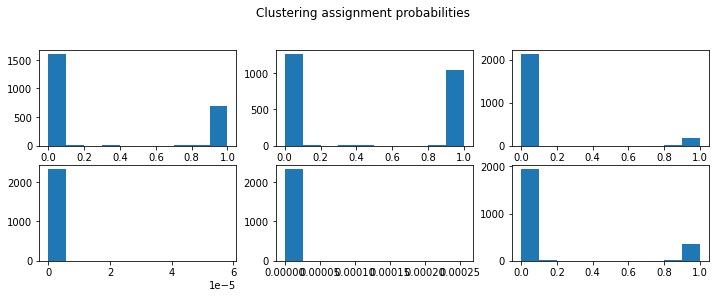

[0 1 2 5]


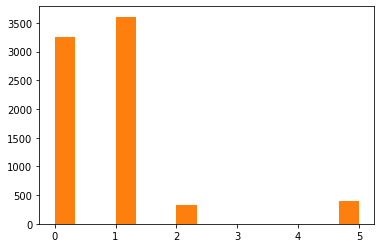

AUROC: [0.88063352 0.85026733 0.87599105]
AUPRC: [0.13928127 0.85085517 0.75710277]
NMI:0.2905, RI:0.3345, PURITY:0.8145


In [26]:
_, tmp_pi, tmp_m = model.predict_zbars_and_pis_m2(te_data_x)

tmp_pi = tmp_pi.reshape([-1, K])[tmp_m.reshape([-1]) == 1]

ncol = nrow = int(np.ceil(np.sqrt(K)))
plt.figure(figsize=[4*ncol, 2*nrow])
for k in range(K):
    plt.subplot(ncol, nrow, k+1)
    plt.hist(tmp_pi[:, k])
plt.suptitle("Clustering assignment probabilities")
plt.show()
# plt.savefig(save_path + 'results/figure_clustering_assignments.png')
plt.close()


# In[147]:


# check selector outputs and intialized classes
pred_y, tmp_m = model.predict_s_sample(tr_data_x)

pred_y = pred_y.reshape([-1, 1])[tmp_m.reshape([-1]) == 1]
print(np.unique(pred_y))

plt.hist(pred_y[:, 0], bins=15, color='C1', alpha=1.0)
plt.show()
# plt.savefig(save_path + 'results/figure_clustering_hist.png')
plt.close()


tmp_y, tmp_m = model.predict_y_bars(te_data_x)


y_pred = tmp_y.reshape([-1, y_dim])[tmp_m.reshape([-1]) == 1]
y_true = te_data_y.reshape([-1, y_dim])[tmp_m.reshape([-1]) == 1]


AUROC = np.zeros([y_dim])
AUPRC = np.zeros([y_dim])
for y_idx in range(y_dim):
    auroc, auprc = f_get_prediction_scores(y_true[:, y_idx], y_pred[:, y_idx])
    AUROC[y_idx] = auroc
    AUPRC[y_idx] = auprc

print('AUROC: {}'.format(AUROC))
print('AUPRC: {}'.format(AUPRC))

pred_y, tmp_m = model.predict_s_sample(te_data_x)

pred_y = (pred_y * tmp_m).reshape([-1, 1])
pred_y = pred_y[(tmp_m.reshape([-1, 1]) == 1)[:, 0], 0]

true_y = (te_data_y * np.tile(np.expand_dims(tmp_m, axis=2), [1,1,y_dim])).reshape([-1, y_dim])
true_y = true_y[(tmp_m.reshape([-1]) == 1)]
true_y = np.argmax(true_y, axis=1)

tmp_nmi    = normalized_mutual_info_score(true_y, pred_y)
tmp_ri     = adjusted_rand_score(true_y, pred_y)
tmp_purity = purity_score(true_y, pred_y)

print('NMI:{:.4f}, RI:{:.4f}, PURITY:{:.4f}'.format(tmp_nmi, tmp_ri, tmp_purity))

In [27]:
AUPRC.mean()

0.5824130691662095